# 7章 畳み込みニューラルネットワーク(convolutional neural network: CNN)
* CNNは画像認識や音声認識などいたるところで使われている
* 画像認識のコンペでは，ほとんどすべてがCNNベースである

## 7.1 全体の構造
* CNNもこれまでのニューラルネットワークと同じくレイヤを組み合わせて作る
* CNNでは「Convolutionレイヤ（畳み込み層）」と「Poolingレイヤ（プーリング層）」が加わる
* これまでのネットワークでは隣接する層の全ニューロン間が結合されていた（全結合：fully-connected）
  * 全結合層はAffineレイヤという名称で実装した
  * Affineレイヤの後にReLUを接続し，それを何回か繰り返したのち，最終出力では Affineレイヤ$\rightarrow$Softmaxレイヤの順で出力する
* CNNの場合の構成
  * Convolutionレイヤ$\rightarrow$ReLUレイヤ$\rightarrow$Poolingレイヤの順で接続し，それを何回か繰り返し，最終出力では全結合ネットワークと同様にAffineレイヤ$\rightarrow$Softmaxレイヤで出力する
  * Poolingレイヤは省略されることもある

## 7.2 畳み込み層
### 7.2.1 全結合層の問題点
* 全結合層のニューラルネットワークではAffineレイヤを使用した
  * 隣接する層のニューロンが全て連結される
  * 出力の数は任意に決めることができる
* Affineレイヤの問題点は，データの形状が無視されること
  * 例）画像は本来「縦，横，チャネル」の方向の広がりを持った3次元形状のデータである
  * 3次元データをAffineレイヤへ入力するには，データを1次元に変換する必要がある
  * 画像では隣接するピクセル間に類似性があるなど，なんらかのパターンが含まれる
  * Affineレイヤはパターンを無視して入力データを扱い，パターンの情報を生かすことがない
* 畳み込み層は形状を維持
  * 画像の場合，入力を3次元データとして受け取り，3次元データとして次の層に出力
    * （参考）CNNでは畳み込み層の入出力データのことを**特徴マップ（feature map）**，**入力特徴マップ**，**出力特徴マップ**のように呼ぶ場合がある
  * 形状を維持するため，形状やパターンのデータをうまく扱える可能性が残る

### 7.2.2 畳み込み演算
* 畳み込み層では畳み込み演算を行う
  * 畳み込み演算は画像処理でいうところのフィルター演算に相当する
* 畳み込み演算は，「入力データ」に対して「フィルター」を適用する
  * 入力データおよびフィルタはともに縦横の形状をもつ
  * フィルタは「カーネル」と呼ばれることもある
* 畳み込み演算は入力データに対してフィルターのウィンドウを一定間隔でスライドさせながら適用させる
  * それぞれの場所でフィルタの要素と入力の対応する要素を乗算し，その和を計算する（積和演算）
  * その和の値を出力の対応する場所へ格納する
  * このプロセスをすべての場所で行うことで畳み込み演算の出力を得る
* Affineレイヤでは重みパラメータの他にバイアスが存在した．
* CNNの場合，フィルタのパラメータが重みに対応する．またバイアスも存在する
  * バイアスは(1,1)のデータで，フィルタ適用後の結果の全要素にそれぞれ加算される

### 7.2.3 パディング(padding)
* 出力サイズを調整するために，入力データの周囲に固定のデータを埋めること
  * 例えば「幅1のパディングを適用する」とは，周囲を幅1ピクセルの0で埋める
* パディングすると出力は大きくなる

### 7.2.4 ストライド(stride)
* フィルターを適用する位置の間隔
* 例えば，ストライドを2にすると，積和演算のためのフィルタは2要素ずつ移動する
* ストライドを大きくすると出力は小さくなる
* サイズの関係: $OH, OW$の計算結果は整数にならなければならないことに注意（割り切れること）
  * 入力サイズ $(H,W)$
  * フィルターサイズ $(FH,FW)$
  * 出力サイズ $(OH, OW)$
  * パディング $P$
  * ストライド $S$
$$OH=\frac{H+2P-FH}{S}+1 \\
OW=\frac{W+2P-FW}{S}+1$$

### 7.2.5 3次元データの畳み込み演算
* 画像の場合は縦横だけでなくチャネル方向も合わせた3次元で扱う必要がある
* チャネル方向も合わせた3次元データに対する畳み込み演算を考える
* チャネルごとに特徴マップがある場合，チャネルごとに入力データとフィルタの畳み込み演算を行い，チャネルごとの結果を加算して一つの出力を計算する
* 注意点：入力データとフィルタのチャネル数は同じにする
  * フィルタのサイズは自由に設定できる

### 7.2.6 ブロックで考える
* 前節では複数チャネル（チャネル数 $C$）からなる画像データ(サイズ $H \times W$)に，それと同じチャネル数($C$)のフィルタ(サイズ $FH \times FW$)を適用して一つの（チャネルが1の）出力特徴マップ(サイズ $OH \times OW$)を得た
* 複数チャネル($FN$個)からなる出力特徴マップを得るにはどうしたら良いか $\rightarrow$ 複数($FN$個)のフィルタを用いる
* 畳み込み演算のフィルタはフィルタの個数$(FN)$も考慮すると4次元のデータとなる
  * (出力チャネル数，入力チャネル数，出力縦，出力横)
    * チャネル数3, サイズ5$\times$5 のフィルタが20個ある場合は $(20, 3, 5, 5)$
* 畳み込み演算のバイアスは出力チャネル数を考慮すると (FN, 1, 1) となる
  * チャネルごとに同じバイアス値がチャネル内の全要素に加算される
* まとめ
  * 入力特徴マップ $(C, H, W)$
  * フィルタ $(FN, C, FH, FW)$
  * バイアス $(FN, 1, 1)$
  * 出力特徴マップ $(FN, OH, OW)$

### 7.2.7 バッチ処理
* バッチを考慮しない場合の入力特徴マップは $(C, H, W)$，出力は $(FN, OH, OW)$
* バッチ処理を考慮する場合，複数($N$個)のデータをまとめて処理することになり，それが畳み込み層へ入力される
* したがってバッチ処理を考慮すると，レイヤの特徴マップは4次元になる：入力 $(N, C, H, W)$ および出力 $(N, FN, OH, OW)$

## 7.3 プーリング層
* プーリングは縦・横方向の空間を小さくする演算
* 複数の要素を一つに集約するような処理を行うことで，空間を小さくする
* 最大値をとるMaxプーリングや平均をとるAverageプーリングなどがある
  * ここではMaxプーリングのみを使用する

### 7.3.1 プーリング層の特徴
* 学習するパラメータがない
  * 入力データだけを使って行う処理なので，学習が必要ない
* チャネル数は変化しない
  * チャネルごとに処理を行い，まとめないためチャネル数は変わらない
* 微小な位置変化に対してロバストである
  * 多少ずれても同じような結果となる（必ずしも同じにはならないことに注意）


## 7.4 Convolution/Poolingレイヤの実装
* レイヤなのでこれまでと同様，forward と backward というメソッドを持つ

### 7.4.1 4次元配列
* CNNの各層を流れるデータは（バッチおよびチャネルを考慮して）4次元データ

In [8]:
# coding: utf-8
# 以降の実装のための準備
import numpy as np
import sys, os
sys.path.append(os.pardir)
sys.path.append(os.pardir + "/deep_learning_from_scratch")

import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient

import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

In [20]:
# 適当な4次元配列をためしてみる

# バッチサイズ10，チャネル1，縦横それぞれ5のデータとして生成
x = np.random.rand(10, 1, 5, 5)

# 形状を確認
print(x.shape)

# 一つ目のデータにアクセス．この場合 (1, 5, 5) のサイズの配列が表示される
print(x[0])
# 一つ目のデータの最初のチャネルデータにアクセス．(5, 5)のサイズの配列が表示される
print(x[0][0])

(10, 1, 5, 5)
[[[ 0.14084385  0.44877728  0.08259538  0.26756363  0.51643597]
  [ 0.23653813  0.83853972  0.18114949  0.04358095  0.62453826]
  [ 0.27176381  0.21895837  0.32422096  0.18849354  0.51831539]
  [ 0.91518921  0.45949892  0.39380019  0.64429486  0.61655682]
  [ 0.39665545  0.62127406  0.36000038  0.6740223   0.47409886]]]
[[ 0.14084385  0.44877728  0.08259538  0.26756363  0.51643597]
 [ 0.23653813  0.83853972  0.18114949  0.04358095  0.62453826]
 [ 0.27176381  0.21895837  0.32422096  0.18849354  0.51831539]
 [ 0.91518921  0.45949892  0.39380019  0.64429486  0.61655682]
 [ 0.39665545  0.62127406  0.36000038  0.6740223   0.47409886]]


### 7.4.2 im2col による展開
* 畳み込み演算を愚直に実装するとforを多段に入れ子にした（ネストした）コードになる．
  * Numpyでは性能が問題となる
* そこで，for の代わりに im2col という関数を使用する
  * 元の行列から，畳み込み領域の要素を1行に展開した行列を生成する
  * ストライドが小さい場合，畳み込みの各領域が重なりを持つため，結果の行列は重複要素を含み，サイズが大きくなる
  * サイズが大きいとメモリ使用量が増大する点が難点だが，既存の線形代数ライブラリを有効活用できるという利点がある
* 既存の[Caffe](http://caffe.berkeleyvision.org/)や[Chainer](https://chainer.org)などのフレームワークでも同様の関数が用意されていて，畳み込み層の実装で用いられている

#### im2col を利用した畳み込み計算の概要
例として次のような畳み込みを計算する場合を考える．
<img src="./fig7_1.png">

畳み込み演算を単なる行列の積として計算するために入力データを行列に変換する．

1回のフィルター適用領域を1行に展開する．
<img src="./fig7_2.png">

結果として得られる行列の形状は次のように変化する．
<img src="./fig7_3.png">

同様に，フィルタも行列の積演算として処理するために変換する．
<img src="./fig7_4.png">

行列計算によって得られたベクトル（1階のテンソル）を出力の形状に戻す．
<img src="./fig7_5.png">

チャネル数が増える場合を考える．チャネル数が増えた場合，各チャネル毎の計算結果を足し合わせるため，同じ行に別チャネルの列を追加するように配置する．フィルタもそれに合わせて配置する．
<img src="./fig7_6.png">

さらに，データ数及びフィルタ数が増えた場合．データ数が増えた場合は行方向に行列が大きくなる．フィルタ数を増やした場合は，列方向にフィルタの行列が大きくなる．
<img src="./fig7_7.png">

演算結果は（N\*OH\*OW,FN）の2次元配列として得られる．これを(N,FN,OH,OW)の形式に変換する
<img src="./fig7_8.png">

In [11]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
    
    Returns
    -------
    col : 2次元配列
    """
    
    # 入力データのサイズを取得
    N, C, H, W = input_data.shape
    
    # 出力画像サイズの計算
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    
    # 入力画像の縦横(インデックス2と3)の両端にpad個ずつ定数(0)をパディング
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    # 展開後の入力データを格納する行列 col の生成
    # (参考) https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    
    # 入力画像の要素をコピー
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    # 軸の順番の入れ替えおよび2次元配列化．
    # 2次元配列の最初の軸は出力データに関するもの，後の軸は積和計算に関するもの．
    #   行数：（データ数＊出力縦＊出力横）
    #   列数：（フィルタ縦＊フィルタ横＊チャネル数）
    # 2次元配列化により畳み込みの積和演算が，内積演算で処理できる．
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


In [32]:
# numpy.pad 関数の動作確認
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
x = np.random.rand(3, 1, 5, 5)
print(x.shape)
img1 = np.pad(x, [(0,1), (0,0), (0, 0), (0, 0)], 'constant')
print("img1.shape = " + str(img1.shape))
print(img1)

img2 = np.pad(x, [(0,0), (1,0), (0, 0), (1, 1)], 'constant')
print("img2.shape = " + str(img2.shape))
print(img2)

(3, 1, 5, 5)
img1.shape = (4, 1, 5, 5)
[[[[ 0.28981795  0.94335224  0.16759254  0.51064916  0.51907792]
   [ 0.88910699  0.67006615  0.93838163  0.91331215  0.1362478 ]
   [ 0.86330053  0.73345959  0.43265135  0.64279587  0.67624462]
   [ 0.46676798  0.79193652  0.31141779  0.09006213  0.21030867]
   [ 0.19947278  0.20238957  0.66646271  0.30048313  0.76573688]]]


 [[[ 0.71151034  0.73488454  0.12920365  0.08388241  0.61698579]
   [ 0.65991212  0.25294023  0.52659918  0.52819977  0.65296523]
   [ 0.52702705  0.99782246  0.62043388  0.23669227  0.18469759]
   [ 0.60886588  0.9689133   0.87950377  0.29845623  0.65828543]
   [ 0.69721743  0.14873872  0.46249634  0.5700789   0.35870759]]]


 [[[ 0.65883921  0.19150488  0.82305559  0.99961838  0.27046773]
   [ 0.93929027  0.5125369   0.07273421  0.22998071  0.67924134]
   [ 0.42951898  0.96056655  0.88902344  0.6062448   0.92113958]
   [ 0.85502057  0.09458369  0.44427512  0.20961625  0.61240537]
   [ 0.70254245  0.2229548   0.98952363  0.

In [5]:
# numpy.transpose の動作確認
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.transpose.html
# 要素が全て1の3次元配列を生成し，形状を確認
x = np.ones((2,1,3))
print(x.shape)

# 特定の要素のみ値を変えてみる
x[0][0][2] = 5
x[1][0][1] = 3
print(x)

# 形状を変換する．3番目の軸を1番目に，1番目の軸を2番目に，2番目の軸を3番目に
x2 = x.transpose(2,0,1)
print("x2.shape = " + str(x2.shape))
print("x2 = " + str(x2))

(2, 1, 3)
[[[ 1.  1.  5.]]

 [[ 1.  3.  1.]]]
x2.shape = (3, 2, 1)
x2 = [[[ 1.]
  [ 1.]]

 [[ 1.]
  [ 3.]]

 [[ 5.]
  [ 1.]]]


### 7.4.3 Convolutionレイヤの実装


In [13]:
# im2colを使ってみる
# 入力画像サイズ(7,7)，チャネル数3，データ数1
x1 = np.random.rand(1, 3, 7, 7)
# フィルタのサイズ(5,5), パディングなし，ストライド1
print(x1.shape)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
# 形状を出力．(データ数*出力縦*出力横，チャネル数*フィルタ縦*フィルタ横) となるはず．
# 出力画像サイズが(3,3)になるため，その場合，col1のサイズは(1*3*3, 3*5*5)=(9,75)
print(col1.shape)

# データ10個とする場合．単純に結果の行数が10倍になる
x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(1, 3, 7, 7)
(9, 75)
(90, 75)


In [33]:
# com2im の実装(common/utils.pyより)
# 畳み込みレイヤおよびPoolingレイヤの逆伝播で使用する
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad
    
    Returns
    -------
    
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)
    
    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]
    
    return img[:, :, pad:H + pad, pad:W + pad]

In [37]:
# col2im を使ってみる

# 行列サイズ(10*3*3, 3*5*5)
# N=10, C=3, OH=3, OW=3, FH=5, FW=5
col1 = np.random.rand(90, 75)
print(col1.shape)

# 入力サイズ(N=10, C=3, H=7, W=7), FH=5, FW=5, ストライド1, パディングなし
im1 = col2im(col1, (10,3,7,7), 5, 5, stride=1, pad=0)

# 形状を出力．(データ数, チャネル数, 画像縦, 画像横) となる
print(im1.shape)

(90, 75)
(10, 3, 7, 7)


In [15]:
# 畳み込み層の実装
class Convolution:
    # W: フィルタ．(データ数，チャネル数，フィルタ高さ，フィルタ幅)の4次元配列
    # b: バイアス．データ数の1次元配列
    # stride: ストライド（既定値1）
    # pad: パディング幅(既定値0)
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    # 順方向処理
    # x: 入力データ．（データ数，チャネル数，高さ，幅）の4次元配列
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        
        # 入力画像からフィルタリング用の2次元配列を生成
        # 形状は（データ数＊出力高さ＊出力幅，チャネル数＊フィルタ高さ＊フィルタ幅）
        col = im2col(x, FH, FW, self.stride, self.pad)
        # フィルタの展開．（1個あたりFH*FW*Cのサイズの列ベクトルがFN個並んだ行列になる）
        col_W = self.W.reshape(FN, -1).T
        
        out = np.dot(col, col_W) + self.b
        # 4次元配列に戻し，軸の順序を入れ替え．4番目の軸(フィルタ個数)を2番目にもってくる．
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        self.x = x
        self.col = col
        self.col_W = col_W
        
        return out
    
    # 逆伝播
    # Affineレイヤとほぼ同様
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        
        return dx


### 7.4.4 Poolingレイヤの実装
* Convolutionレイヤと同様にim2colを使って入力データを展開する
* プーリングの場合はチャンネル方向には独立であるため，プーリングの適用領域はチャンネルごとに独立して展開する
* 展開後は，展開した行列に対して，行ごとに最大値を計算し，適切な形状に整形するだけ
* Poolingレイヤ実装の流れ
  1. 入力データを展開する
  2. 行ごとに最大を求める
    * 最大値の計算には numpy.max 関数が利用できる．
  3. 適切な出力サイズに整形する
* 逆伝播は ReLUレイヤの説明が参考になる

In [16]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None
    
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        self.x = x
        self.arg_max = arg_max
        
        return out
    
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


## 7.5 CNNの実装

In [17]:
class SimpleConvNet:
    """単純なConvNet
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        
        self.last_layer = SoftmaxWithLoss()
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
    
    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]
    
    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）
        
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)
        
        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])
        
        return grads
    
    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）
        
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        
        return grads
    
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)
    
    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val
        
        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

In [18]:

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()



train loss:2.29982078687
=== epoch:1, train acc:0.097, test acc:0.093 ===
train loss:2.29814264546
train loss:2.29312690768
train loss:2.29130448073
train loss:2.28486122169
train loss:2.27396438766
train loss:2.2609443809
train loss:2.2547972833
train loss:2.22749704666
train loss:2.19238656437
train loss:2.18857932475
train loss:2.14215049867
train loss:2.12754425337
train loss:2.11193860628
train loss:2.04760611497
train loss:1.94512738092
train loss:1.94825039358
train loss:1.83961362176
train loss:1.80463576908
train loss:1.76130594112
train loss:1.61866591206
train loss:1.57167187541
train loss:1.45162544261
train loss:1.47890638082
train loss:1.27823143246
train loss:1.1819408184
train loss:1.20947187787
train loss:1.14849309266
train loss:1.00615921432
train loss:0.925956617895
train loss:1.04173659917
train loss:0.950833135383
train loss:0.806805901061
train loss:0.707438734183
train loss:0.968911716525
train loss:0.836264245118
train loss:0.655616198161
train loss:0.660431518

train loss:0.199182414608
train loss:0.188224213419
train loss:0.338752163804
train loss:0.298441289706
train loss:0.188846014907
train loss:0.279361884812
train loss:0.13936632684
train loss:0.228002842682
train loss:0.235690694146
train loss:0.155697448005
train loss:0.162027794356
train loss:0.161821484478
train loss:0.105036514301
train loss:0.155183819589
train loss:0.199474422564
train loss:0.178727484518
train loss:0.14637596796
train loss:0.166152914151
train loss:0.234538179039
train loss:0.182165691787
train loss:0.237921377026
train loss:0.371741488282
train loss:0.162254963943
train loss:0.187891110906
train loss:0.150909610879
train loss:0.0972380993208
train loss:0.156432303066
train loss:0.26403281153
train loss:0.182469454249
train loss:0.0986637499152
train loss:0.0833614808708
train loss:0.181911105967
train loss:0.188309385413
train loss:0.339524059767
train loss:0.13803136667
train loss:0.229634613836
train loss:0.0666237956553
train loss:0.245825341675
train loss:0

train loss:0.16203849658
train loss:0.0847128437727
train loss:0.117833252307
train loss:0.0991971866639
train loss:0.115128272818
train loss:0.128209017005
train loss:0.187799624281
train loss:0.088585948457
train loss:0.0847154380915
train loss:0.259228722923
train loss:0.144138169986
train loss:0.119046145825
train loss:0.164655968628
train loss:0.159545728935
train loss:0.0995289040491
train loss:0.0635226399413
train loss:0.10888688461
train loss:0.144175772193
train loss:0.10553298336
train loss:0.057168261444
train loss:0.0530401446768
train loss:0.0934062411107
train loss:0.143436881081
train loss:0.119586708837
train loss:0.119511469643
train loss:0.111915818853
train loss:0.064349383576
train loss:0.0846751641976
train loss:0.230637539319
train loss:0.0497390451339
train loss:0.132786808706
train loss:0.115492769404
train loss:0.253633203378
train loss:0.0425220683896
train loss:0.0727113738344
train loss:0.119910502044
train loss:0.281315332021
train loss:0.0649975499608
tra

KeyboardInterrupt: 

## 7.6 CNNの可視化
* 畳み込み層を可視化することでCNNで何が行われているのかを探索する
### 7.6.1 1層目の重みの可視化

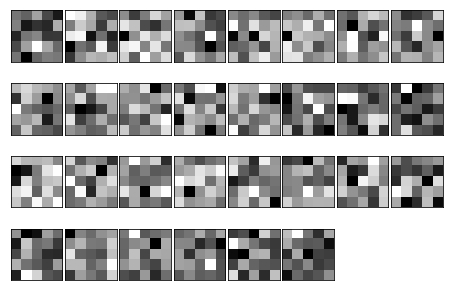

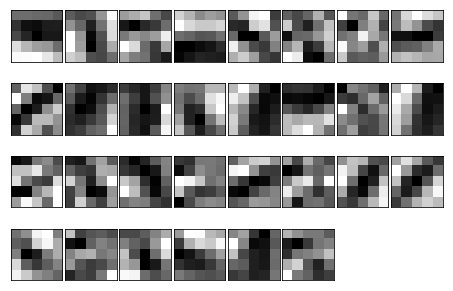

In [70]:
def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))
    
    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    
    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])

### 7.6.2 階層構造による情報抽出
* 先の結果の考察
  * 1層目の畳み込み層を対象とした結果である
  * 1層目ではエッジやブロブなどの低レベルな情報が抽出される
  * ディープラーニングの可視化に関する研究では，層が深くなるに従い抽出される情報はより抽象化されていくことが示されている
    * AlexNetのネットワーク構成は畳み込み層とプーリング層が何層にも重なり，最後に全結合層を経て結果が出力される
  * 畳み込み層を何層も重ねると，層が深くなるにつれ，より複雑で抽象化された情報が抽出される
  * 最初の層は単純なエッジに反応し，次にテクスチャに反応し，そしてより複雑な物体のパーツへと反応するように変化する
    * 層が深くなるに従い，単純な形状から高度な情報へと変化する．
    * ものの意味を理解するかのように反応する対象が変化する．

## 7.7 代表的なCNN
* CNNは様々な構成のネットワークが提案されてきた
* LeNetおよびAlexNetは特に重要なネットワークである

### 7.7.1 LeNet
* CNNの元祖
* 手書き数字認識を行うネットワークとして1998年に提案された
* 畳み込み層とサブサンプリング層（要素を間引く層）を連続して行い，最後に全結合層を経て結果が出力される
* 現在のCNNとの違い
  * シグモイド関数が使われている（現在は主にReLUが使われる）
  * サブサンプリングによって中間データのサイズを縮小している（現在はMaxプーリングが主流） 

### 7.7.2 AlexNet
* ディープラーニングが注目されるに至ったCNN．2012年に提案された．
* 畳み込み層とプーリング層を重ね，最後に全結合層を経由して結果を出力する
* 基本構成はLeNetと変わらないが，以下の点で異なる
  * ReLUを使用する
  * LRN(Local Response Normalization)という局所的正規化の層を使用する
  * Dropoutを使用する
* LeNetの時代と比べるとコンピューティング環境が変化
  * 大量データの入手が容易になった
  * GPUが普及し，大量の演算を高速に実行可能となった

## 7.8 まとめ
* CNNについて学んだ
  * CNNを構成する基本モジュールは「畳み込み層」と「プーリング層」である
  * CNNはこれまでの全結合層のネットワークに加え，畳み込み層とプーリング層が加わったもの
  * CNNは画像を扱う分野では例外なく使われる
* 畳み込み層とプーリング層はim2colを用いるとシンプルで効率よく実装できる
* CNNの可視化により高度な情報が層を深くするにつれて抽出される様子がわかる
* ディープラーニングの発展にビックデータとGPUが大きく貢献している